# IX Geometry Constrained Feature Matching

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from lib import fundamental_matrix, normalize2d

## Fundamental Matrix Estimation: The Eight Point Algorithm

\begin{align*}
    0 &= \textbf{q}_2^T\textbf{F}\textbf{q}_1\\
    0 &= \textbf{q}_2^T\begin{bmatrix}
        F_{11} & F_{12} & F_{13} \\
        F_{21} & F_{22} & F_{23} \\
        F_{31} & F_{32} & F_{33} \\
    \end{bmatrix}
    \textbf{q}_1 \\
    0 &= \textbf{B}^{(i)} flatten(\textbf{F}^T)
\end{align*}

With
\begin{align*}
    \textbf{B}^{(i)} &= \begin{bmatrix}
    x_{1i}x_{2i} & x_{1i}y_{2i} & x_{1i} & 
    y_{1i}x_{2i} & y_{1i}y_{2i} & y_{1i} &
          x_{2i} &       y_{2i} & 1
    \end{bmatrix}\\
    flatten(\textbf{F}^T) &= \begin{bmatrix}
        F_{11} & F_{21} & F_{31} & 
        F_{12} & F_{22} & F_{32} & 
        F_{13} & F_{23} & F_{33} \\
    \end{bmatrix}
\end{align*}

The solution is the smallest singular vector of:
\begin{align*}
    \textbf{B} = \begin{bmatrix}
        \textbf{B}^{(1)} \\ \textbf{B}^{(2)} \\ \vdots \\ \textbf{B}^{(n)} \\
    \end{bmatrix}
\end{align*}
Subject to $||flatten(\textbf{F}^T)||_2 = 1$.

F has 9 numbers and is scale invariant. Each pair of corresponding point fixes a degree of freedom, therefore this method enables us to estimate the fundamental matrix using eight points.


We can normalize the points before using them:
\begin{align*}
    0 &= \textbf{q}_2^T \textbf{F}\textbf{q1}\\
    0 &= (T_2\textbf{q}_2)^T \textbf{F}'(T_1\textbf{q1})\\
    0 &= \textbf{q}_2^T (T_2^T \textbf{F}'T_1)\textbf{q1}\\
    F &= T_2^T \textbf{F}'T_1
\end{align*}

#### Data

In [2]:
two_image_data = np.load('data/TwoImageData.npy', allow_pickle=True).item()

im1 = two_image_data["im1"]
im2 = two_image_data["im2"]

R1 = two_image_data["R1"]
R2 = two_image_data["R2"]

t1 = two_image_data["t1"]
t2 = two_image_data["t2"]

K1 = two_image_data["K"]
K2 = K1.copy()

F_true = fundamental_matrix(K1, K2, R2, t2, R1=R1, t1=t1)
F_true /= np.linalg.norm(F_true) * np.sign(F_true[2, 2])
F_true

array([[-3.07914555e-08,  3.61883689e-06, -5.43583727e-04],
       [ 4.49876682e-06,  2.24402705e-08, -1.51520136e-01],
       [-1.95223414e-03,  1.48295604e-01,  9.77264527e-01]])

In [3]:
qs = np.load('data/qs.npy', allow_pickle=True).item()
q1 = qs["q1"]
q2 = qs["q2"]

### 1. Estimation of F

In [4]:
def Fest_8point(q1, q2):
    """Estimate a fundamental matrix from 8 or more point correspondences.
    
    Uses the linear 8 point algorithm.

    Parameters
    ----------
    q1, q2: 3 x n numpy arrays
        sets of points
    Return
    ------
    F: 3x3 numpy array
        Estimated fundamental matrix.
    """
    T1, q1 = normalize2d(q1)
    T2, q2 = normalize2d(q2)
    B = _get_fundamental_B(q1, q2)
    u, s, vh = np.linalg.svd(B)
    F = np.reshape(vh[-1, :], (3, 3), 'F')
    F = T2.T @ F @ T1
    return F / np.linalg.norm(F) / np.sign(F[2, 2])


def _get_fundamental_B(q1, q2):
    """Helper function to compute the fundamental matrix.

    Parameters
    ----------
    q1, q2: 3 x n numpy arrays
        sets of points
    """
    B = _get_fundamental_B_i(q1, q2, 0)
    for i in range(1, len(q1[0])):
        B = np.vstack((B, _get_fundamental_B_i(q1, q2, i)))
    return B


def _get_fundamental_B_i(q1, q2, i):
    """Helper function to compute the fundamental matrix.

    Parameters
    ----------
    q1, q2: 3 x n numpy arrays
        sets of points
    """
    x1, y1 = q1[:2, i]
    x2, y2 = q2[:2, i]
    return np.array([
        x1 * x2, x1 * y2, x1,
        y1 * x2, y1 * y2, y1,
             x2,      y2,  1
    ])

In [5]:
Fest = Fest_8point(q1, q2)
Fest /= Fest[2, 2]

In [6]:
print("Numerical error: {:.0e}".format(np.linalg.norm(Fest - F_true)))

Numerical error: 2e-02


## 7 points algorithm

\begin{align*}
    \textbf{E} &= [\textbf{t}]_\times \mathbf{R}\\
    \textbf{F} &= \textbf{K}_2^{-T}\textbf{EK}_1^{-1}
\end{align*}

$[\textbf{t}]_\times$ has rank 2, thus $\textbf{F}$ is rank deficient, thus it has only 7 degrees of freedom and can be computed using only 7 matches.

$\textbf{B}$ will have two singular vector with value 0 that we denote $F'$ and $F''$. We want to find $\alpha$ such that:
\begin{align*}
    det(\textbf{F}) = 0 \quad with \quad \textbf{F} = \alpha \textbf{F}' + (1-\alpha) \textbf{F}''
\end{align*}

This will not be implemented in this notebook.

## Feature matching
### 2. Filter by cross-checking only

In [7]:
def homogeneous(p):
    try:
        _, n = p.shape
    except:
        p.reshape(2, 1)
        n = 1
    return np.vstack((p, np.ones(n)))

def SIFT_features(im1, im2):
    sift = cv2.SIFT_create()
    keypoint1, descriptor1 = sift.detectAndCompute(im1, None)
    keypoint2, descriptor2 = sift.detectAndCompute(im2, None)
    bf = cv2.BFMatcher(crossCheck=True)
    matches = bf.match(descriptor1, descriptor2)

    qm1 = np.array([keypoint1[m.queryIdx].pt for m in matches]).T
    qm2 = np.array([keypoint2[m.trainIdx].pt for m in matches]).T
    qm1 = homogeneous(qm1)
    qm2 = homogeneous(qm2)
    return matches, qm1, qm2, keypoint1, keypoint2

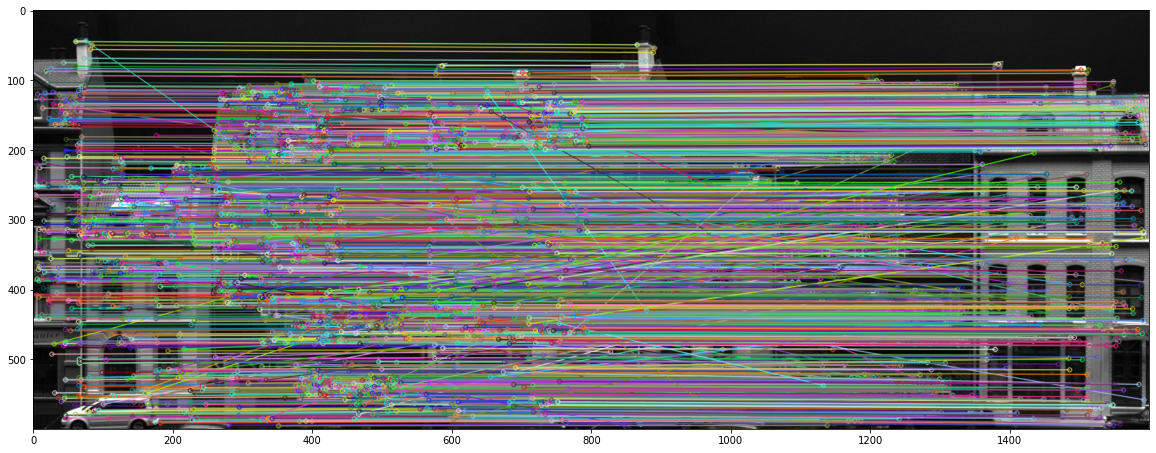

In [8]:
matches, qm1, qm2, keypoint1, keypoint2 = SIFT_features(im1, im2)

im3 = cv2.drawMatches(
    im1, keypoint1,
    im2, keypoint2,
    matches,
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
plt.figure(figsize = (20,20))
plt.imshow(im3);

## Fundamental matrix estimation via RANSAC

#### Metric

$\textbf{q}_{2}^T\textbf{F}$ and $\textbf{Fq}_{1}$ are the epipolar lines. Therefore, if the points do not correspond, then $\textbf{q}_{2}^T\textbf{Fq}_{1}$ is the distance from one of the points to the estimated epipolar line.

In the following, we will use Sampson's Distance:
\begin{align*}
    d_{Samp}(\textbf{F}, \textbf{q}_{1}, \textbf{q}_{2})
    = \frac{(\textbf{q}_{2}^T\textbf{Fq}_{1})^2}{
        (\textbf{q}_{2}^T\textbf{F})_1^2
        + (\textbf{q}_{2}^T\textbf{F})_2^2
        + (\textbf{Fq}_{1})_1^2
        + (\textbf{Fq}_{1})_2^2
    }
\end{align*}

This is a first order approximation of the true squared distance, but in practice it performs slighltly better.

#### Threshold
Notice that the above error, the distance to the epipolar line, is one dimensional, i.e. the codimension $m$ of the problem is 1.

Let us assume that the error of each sample follows a normal distribution with standard deviation $\sigma = 3$. The squared error is $\chi_m^2$ distributed. If we choose a confidence interval of $95\%$:
\begin{align*}
    \tau^2 = 3.84\sigma^2
\end{align*}

In [9]:
def SampsonsDistance(F, q1, q2):
    """Compute Sampson distance to the epipolar lines.
    
    Parameters
    ----------
    F: 3x3 numpy array
        fundamental matrix
    p1, p2: 3x1 numpy arrays
        points. In theory p2^T F p1 = 0
    """
    a = q2.T @ F
    b = F @ q1
    return (q2.T @ F @ q1) ** 2 / (
        a[0] ** 2 + a[1] ** 2 + b[0] ** 2 + b[1] ** 2
    )

In [10]:
def F_RANSAC(set1, set2, threshold=3.84 * 3 ** 2, p=1-1e-6, max_iter=2000):
    """
    Parameters
    ----------
    """
    M = set1.shape[1]
    m = 0
    s = 0
    N = 1
    eps = 0

    while (m < N) and (m < max_iter):
        draw = np.random.choice(list(range(M)), 8, replace=False)
        q1 = set1[:, draw]
        q2 = set2[:, draw]

        F = Fest_8point(q1, q2)
        n_in = np.sum(fundamental_inlier(set1, set2, F, threshold))

        if n_in > s:
            s = n_in
            best_guess = q1, q2

        if s == M:
            return F

        m += 1
        eps = 1 - s / M
        N = np.log(1 - p) / np.log(1 - (1 - eps) ** 2)
    print(m)
    
    inlier_index = fundamental_inlier(set1, set2, F, threshold)
    F = Fest_8point(set1[:, inlier_index], set2[:, inlier_index])
    return F

def F_RANSAC(set1, set2, sigma=3, iterations=500):
    best_inliers = 0
    for i in range(iterations):
        match_idx = np.random.randint(low=0, high=len(set1[0]), size=(8,))
        q1 = set1[:, match_idx]
        q2 = set2[:, match_idx]
        Fest = Fest_8point(q1, q2)
        no_inliers = np.sum(fundamental_inlier(set1, set2, Fest))
        if no_inliers>best_inliers:
            F = Fest
            best_inliers = no_inliers
            print(i, "New best estimate")

    inlier = fundamental_inlier(set1, set2, F)
    F = Fest_8point(set1[:, inlier], set2[:, inlier])
    return F


def fundamental_inlier(p1, p2, F, threshold=3.84 * 3 ** 2):
    """Return the number of inliers.
    
    Parameters
    ----------
    p1, p2: 3 x n numpy arrays 
        sets of points
    H: 3 x 3 numpy array
        Homography matrix
    threshold: float, optional. Default:
        Maximum squared distance for a point to be considered an inlier.
    """
    n = p1.shape[1]
    inlier = [SampsonsDistance(F, p1[:, i], p2[:, i]) < threshold for i in range(n)]
    return inlier

#### With the 8 true points the algorithm finds the true F.

In [11]:
Fest = F_RANSAC(q1, q2)

print("Error: {:.0e}".format(np.linalg.norm(Fest - F_true)))

0 New best estimate
3 New best estimate
Error: 3e-14


#### With the SIFT matches:

In [12]:
threshold = 3.84 * 3 ** 2
Fest = F_RANSAC(qm1, qm2)
print("Error: {:.0e}".format(np.linalg.norm(Fest - F_true)))
print("Scalar product: {:.2f}".format((Fest * F_true).sum() / (np.linalg.norm(Fest) * np.linalg.norm(F_true))))

0 New best estimate
5 New best estimate
8 New best estimate
13 New best estimate
21 New best estimate
36 New best estimate
79 New best estimate
300 New best estimate
Error: 2e-02
Scalar product: 1.00


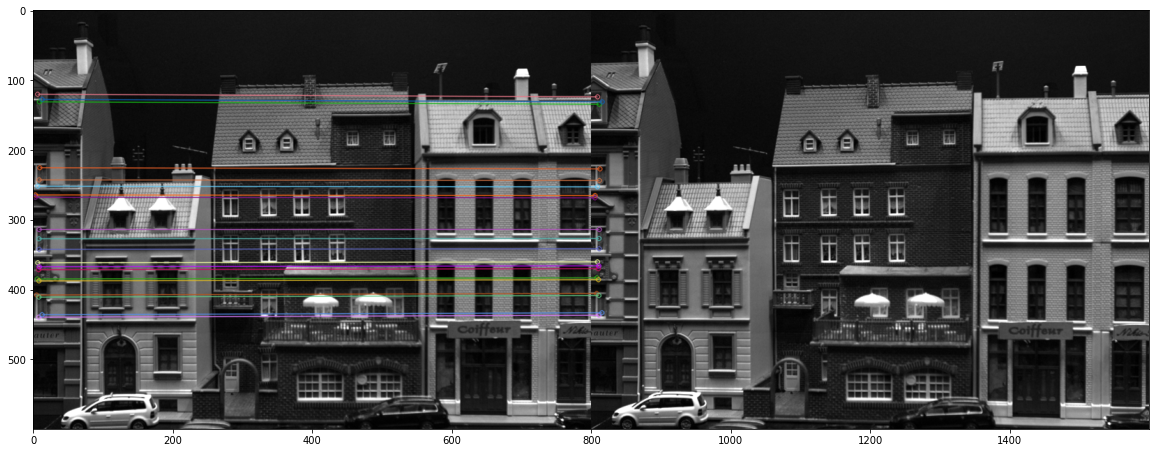

In [13]:
inlier = fundamental_inlier(qm1, qm2, Fest, threshold)

im3 = cv2.drawMatches(
    im1, keypoint1,
    im2, keypoint2,
    np.array(matches)[inlier][:20],
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
plt.figure(figsize = (20,20))
plt.imshow(im3);

### 7. Real world images

In [14]:
imr1_color = cv2.imread("data/notebook1.jpg")[:, :, [2, 1, 0]]
imr2_color = cv2.imread("data/notebook2.jpg")[:, :, [2, 1, 0]]
imr1 = (np.sum(imr1_color, axis=2) // 3).astype("uint8")
imr2 = (np.sum(imr2_color, axis=2) // 3).astype("uint8")

matches, qm1, qm2, kp1, kp2 = SIFT_features(imr1, imr2)

threshold = 3.84 * 3 ** 2
Fest = F_RANSAC(qm1, qm2, threshold)

0 New best estimate
1 New best estimate
5 New best estimate
7 New best estimate
15 New best estimate
16 New best estimate
31 New best estimate
51 New best estimate
103 New best estimate


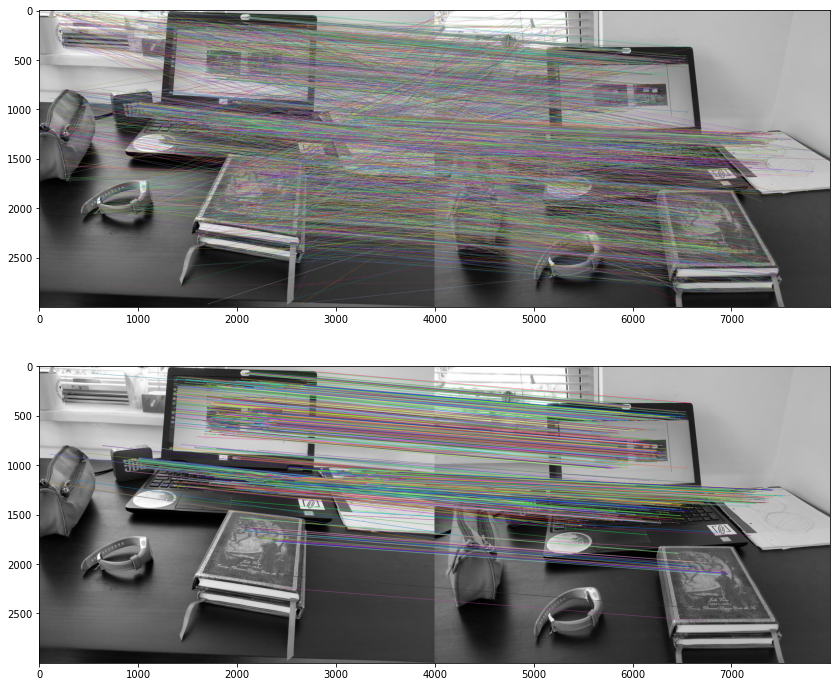

In [15]:
inlier = np.array(
    [SampsonsDistance(Fest, qm1[:, i], qm2[:, i]) < threshold for i in range(qm1.shape[1])]
)

im3 = cv2.drawMatches(
    imr1, kp1,
    imr2, kp2,
    matches,
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
)
im4 = cv2.drawMatches(
    imr1, kp1,
    imr2, kp2,
    np.array(matches)[inlier],
    None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchesThickness=2
)
fig, ax = plt.subplots(2, 1, figsize = (24,12))
ax[0].imshow(im3);
ax[1].imshow(im4);